In [258]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt
from scipy import integrate

In [259]:
# Coordonates of key points
GEI_coordinate = (43.570819, 1.466246) 
LoRa_antenas = [(43.570819, 1.466246)]


In [260]:

def min_max_scaling(series):
    return (series - series.min()) / (series.max() - series.min())


In [261]:

# Python 3 program to calculate Distance Between Two Points on Earth
def distance(lat1, lat2, lon1, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in meters . Use 3956 for miles
    r = 6371000
      
    # calculate the result
    return(c * r)


In [262]:

def create_distance(lattitude, longitude,GEI_coordinate):
    dist = []
    n =len(lattitude)
    for i in range(n) :
        lat=lattitude[i]
        long=longitude[i]
        dist.append(distance(lat, GEI_coordinate[0], long,GEI_coordinate[1]))
    return dist

In [263]:
data = pd.read_csv(r'data.csv')
data.insert(0, 'dist', create_distance(data['lattitude'], data['longitude'], GEI_coordinate))
data.insert(0,'Lp',14-data['rssiPacket'])
data['Lp'].apply(lambda x: float(x))
sorted_data = data.sort_values(by=['dist'])

splitData=[]
for i in range (10):
    splitData.append(sorted_data.iloc[i*100 :(i+1)*100])

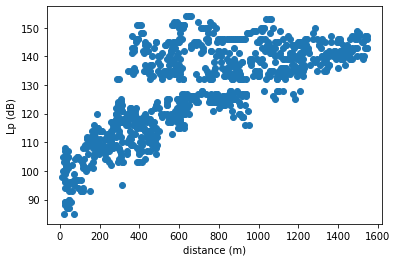

In [264]:
plt.plot(data['dist'],data['Lp'],'o')
plt.ylabel('Lp (dB)')
plt.xlabel('distance (m)')
plt.show()

In [265]:
# LPrmax=120
# sigmarmax = getSigma(Lp,LPrmax)
# def normal(x,mu,std):
#     return 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * std**2))


normal = lambda x,mu,std : 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * std**2))

print(normal(100,120,10))



0.005399096651318806


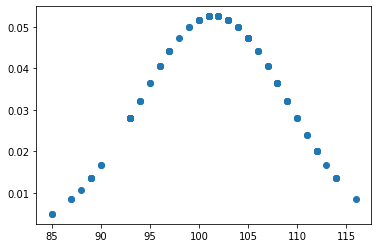

360.29363396687296


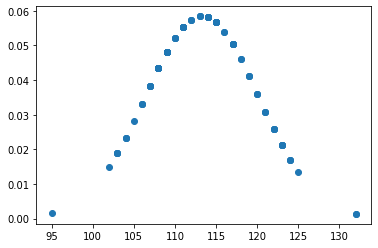

406.3379818096798


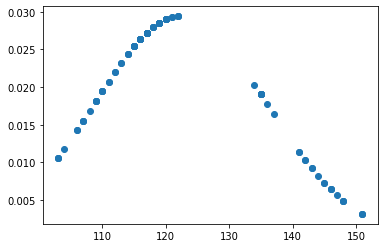

200.6236674637386


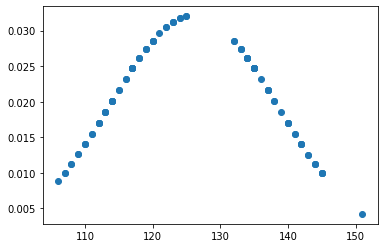

206.5190154580803


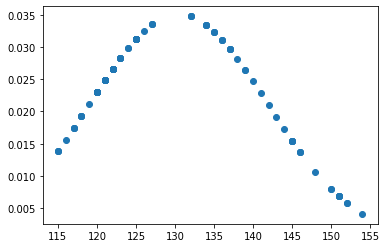

231.62489298992637


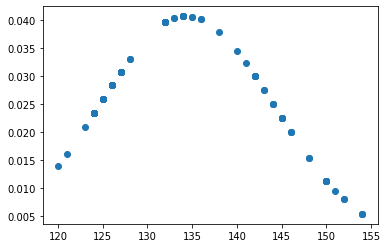

267.4368854332812


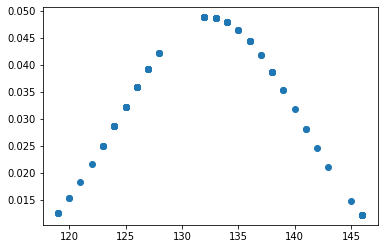

328.8400245128715


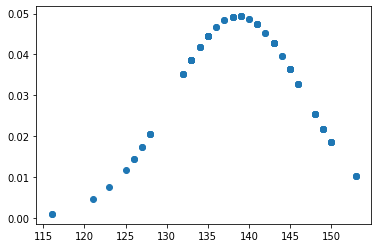

344.24520982424826


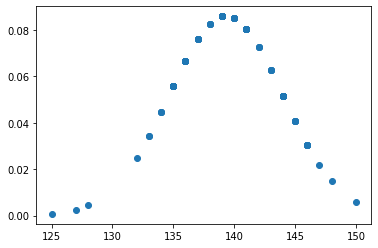

596.8134574355358


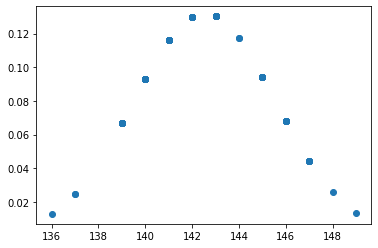

595.4853928199836


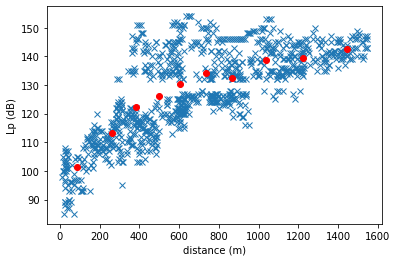

In [269]:
# def getSigma(Lp,mu):
#     result = 0
#     for lp in Lp:
#         result+= (lp-mu)**2
#     return np.sqrt(result/len(Lp))

# print(detSigma(Lp,120))

Means=[]
Dists=[]

for df in splitData :
    Normal=[]
    mu=df['Lp'].mean()
    std=df.std()
    Means.append(mu)
    Dists.append(df['dist'].mean())
    normal = lambda x,mu,std : 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * std**2))

    for lp in df['Lp'] :
        Normal.append(normal(lp,mu,std)['Lp'])

    couv = integrate.trapezoid(Normal)
    
    plt.plot(df['Lp'],Normal,'o')
    plt.show()
    print(couv*100)
    

plt.plot(data['dist'],data['Lp'],'x')
plt.plot(Dists,Means,'or')
plt.ylabel('Lp (dB)')
plt.xlabel('distance (m)')
plt.show() 


In [267]:
plt.plot (Lp, normal(Lp), 'o')
plt.show()

TypeError: <lambda>() missing 2 required positional arguments: 'mu' and 'std'